OBSERVACIONES INICIALES SOBRE LOS DATOS
- Formato "wide": cada SKU en una coluna distinta.
- Las filas son meses (a partir de enero de 2019 en aelante).
- Al tratar demanda intermitente, habrá muchos ceros; convendrá un tratamiento específico para cada serie.

SIGUIENTE PASO PROPUESTO
1. Reformatear los datos a "long" (ID de producto, mes, demanda) para facilitar bucles y funciones genéricas.
2. Revisar el script completo para:
    - Identificar bloques de carga, preprocesado, modelos base y métricas.
    - Detectar dependencias de variables globales y posibles redundancias.
3. Diseñar la estructura modular:
    - Módulo de datos (carga y reshaping).
    - Funciones de cada modelo base (Croston, SBA, SBJ, TSB).
    - Funciones de evaluación (MAE, MAPE, RMSE, etc.).
    - Pipelines de back-test.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display  # sólo necesario en notebook
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS

In [2]:
# Cargar y mostrar una vista previa del dataset
df = pd.read_excel('df_0.xlsx')

PUNTO 1: Convertir el dataframe a formato "long" y encapsularlo en una función.

Creamos la función 'reshape_wide_to_long' y transformamos el dataframe al formato 'long', lo cual facilita aplicar bucles y funciones genéricas sobre cada SKU.
A partir de aquí, tendremos un único esquema de columnas:
- CODE_MONTH: mes de la observación.
- PRODUCT_CODE: código único de producto.
- DEMAND: demanda registrada.

El siguiente paso es integrar esta función dentro del pipeline de datos y empezar a definir los módulos del modelo base. 

In [3]:
# # Función para reshaping de wide a long
# def reshape_wide_to_long(df, date_col = 'CODE_MONTH'):
#     '''
#     Convierte un DataFrame de formato wide a formato long:
#     - date_col: nombre de la columna de fechas.
#     - product_code: identificador de SKUs.
#     - demand: valor de demanda.
#     '''
#     df_long = df.melt(id_vars = [date_col], var_name = 'PRODUCT_CODE', value_name = 'DEMAND')
#     return df_long

# ===== 1) Definición de utilidades y modelos =====
def reshape_wide_to_long(df: pd.DataFrame, date_col: str = 'CODE_MONTH') -> pd.DataFrame:
    df_long = (df.rename(columns={date_col: 'date'}).melt(id_vars=['date'], var_name='product_code', value_name='demand'))
    df_long['date'] = pd.to_datetime(df_long['date'])
    return df_long

# Aplicación de la función y vista previa
df_long = reshape_wide_to_long(df)

pivot_df = df_long.pivot(index='product_code', columns='date', values='demand').fillna(0)
X = pivot_df.values
# Vista previa
# print(df_long.head()) # En script o consola
# display(df_long.head()) # En Jupyter Notebook

In [6]:
# 1) DTW manual
def dtw_dist(a, b):
    n, m = len(a), len(b)
    dtw = np.full((n + 1, m + 1), np.inf)
    dtw[0, 0] = 0.0
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = abs(a[i - 1] - b[j - 1])
            dtw[i, j] = cost + min(dtw[i - 1, j], dtw[i, j - 1], dtw[i - 1, j - 1])
    return dtw[n, m]

n = X.shape[0]
D = np.zeros((n, n))
print('Calculando matriz DTW (puede tardar)...')
for i in range (n):
    for j in range(i + 1, n):
        d = dtw_dist(X[i], X[j])
        D[i, j] = D[j, i] = d

Calculando matriz DTW (puede tardar)...


In [8]:
# 2) Silhouette y Elbow
Ks = range(2, 11)
sil_scores, inertias = [], []

for k in Ks:
    model = AgglomerativeClustering(n_clusters=k, metric='precomputed', linkage='average')
    labels = model.fit_predict(D)
    sil_scores.append(silhouette_score(D, labels, metric='precomputed'))
    # intertia: suma de distancias del medoid en cada cluster
    inertia = 0.0
    for c in np.unique(labels):
        idx = np.where(labels == c)[0]
        subD = D[np.ix_(idx, idx)]
        medoid = idx[np.argmin(subD.sum(axis=1))]
        inertia += D[medoid, idx].sum()
    inertias.append(inertia)

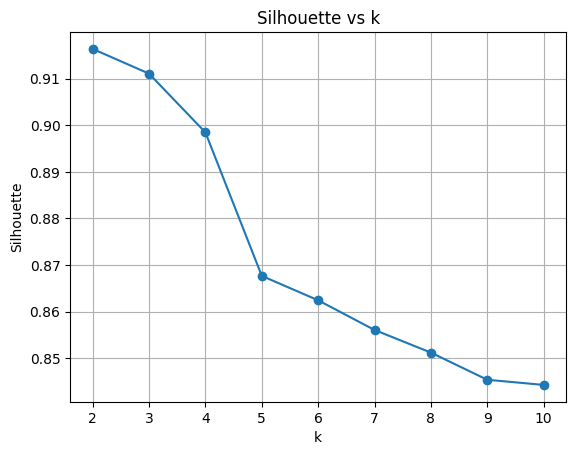

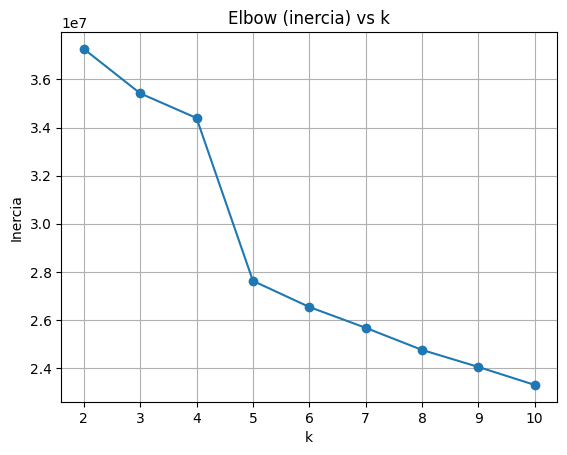

In [21]:
plt.figure()
plt.plot(Ks, sil_scores, 'o-')
plt.title('Silhouette vs k')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(Ks, inertias, 'o-')
plt.title('Elbow (inercia) vs k')
plt.xlabel('k')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

Hay dos visiones complementarias:
1. Silhouette Score
    - Es máximo para k = 2 (aprox. 0.915), baja ligeramente para k = 3 (aprox. 0.91) y sigue descendiendo conforme añadimos clusters: para k = 5 ya está en aprox. 0.868.
    - Un valor de Silhouette > 0.8 suele considerarse 'buena separación', así que k = 5 todavía te da clusters razonablemente bien definidos, pero ya pierdes algo de cohesión respecto a k = 2-3.
2. Elbow (Inercia)
    - La pendiente de la curva sufre un 'codo' fuerte justo al pasar de k = 4 a k = 5, indicando que añadir el quinto cluster aporta una caída importante de la suma de distancias internas.
    - A partir de k = 5, los beneficios (reducción de inercia) son cada vez menores.

- Si la prioridad es máxima cohesión y separación clara entre grupos (menos 'ruido' dentro de cada cluster), tiende hacia k = 2 ó k = 3, donde la Silhouette está cerca de su tope.
    - 2 - 3 clusters si perfieres grupos muy limpios.
- Si la prioridad es capturar más patrones y complejidad (más segmentos), y aún aceptamos una Silhouette >= 0.85, entonces k = 5 es perfectamente defendible: representa el 'codo' en inercia y mantiene clusters razonablemente compactos.
    - 4 clusters como buena mezcla de separación y detalle.
- Un punto intermedio puede ser k = 4: Silhouette aprox. 0.90 (muy bueno) y ya casi alcanzas el gran salot de inercia que sucede en k = 5.
    - 5 clusters si necesitamos granularidad adicional y toleramos algo más de dispersión interna.

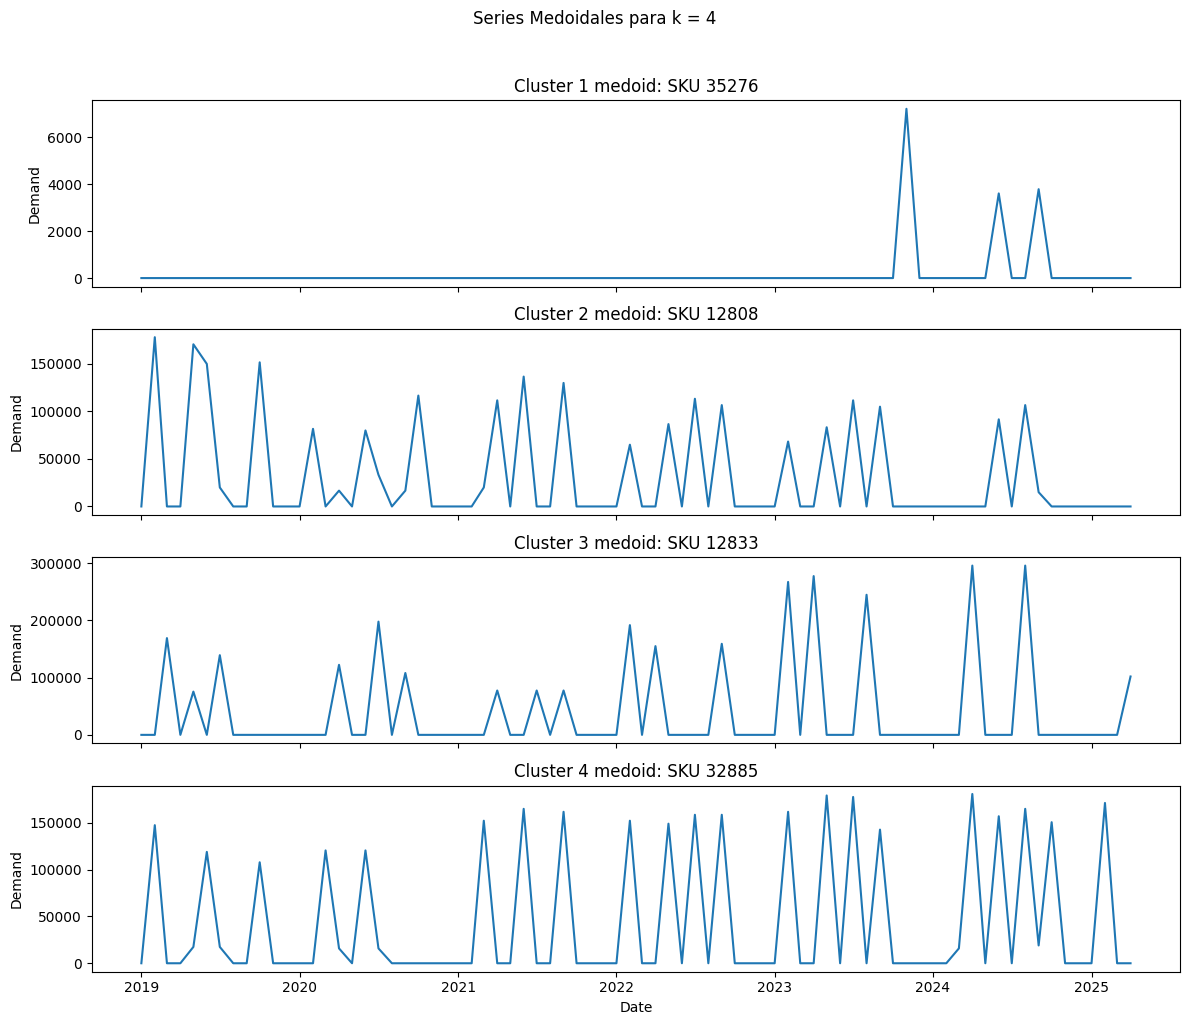

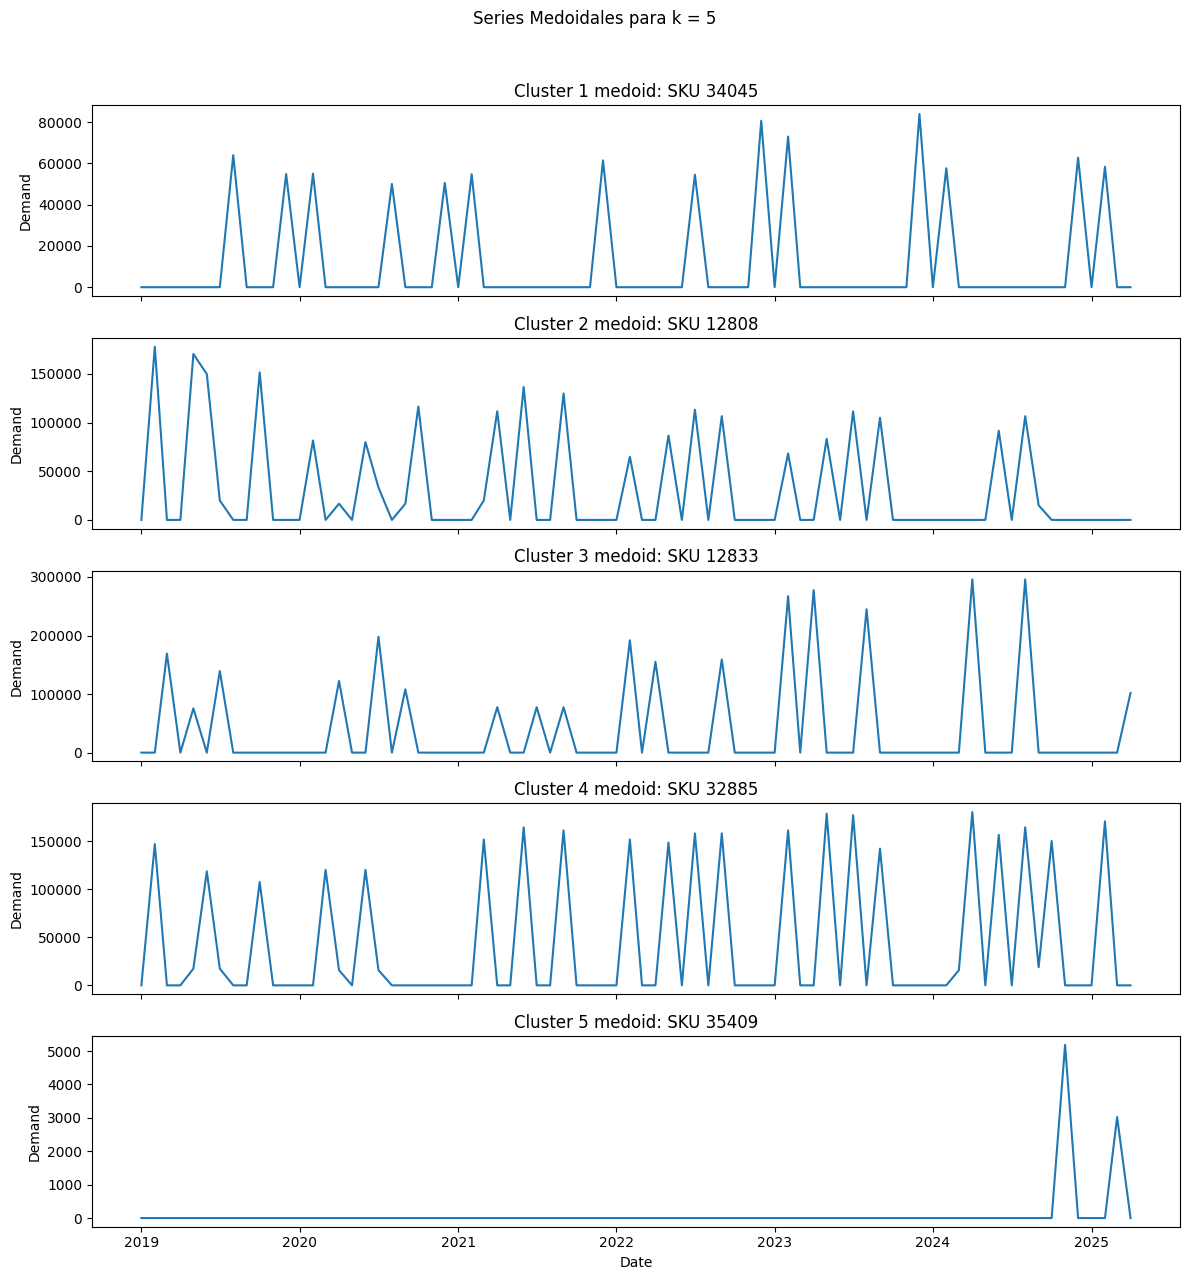

In [38]:
# ===== Asume que ya tienes en el entorno =====
# - pivot_df: DataFrame con index=product_code, columns=fechas
# - D: matriz de distancias DTW (shape (n_series, n_series))

dates = pivot_df.columns

for k in [4, 5]:
    # 1) Clustering con DTW + average linkage
    model = AgglomerativeClustering(
        n_clusters=k,
        metric='precomputed',
        linkage='average'
    )
    labels = model.fit_predict(D)

    # 2) Calcular medoids de cada cluster
    medoids = []
    for cluster in range(k):
        idx = np.where(labels == cluster)[0]
        subD = D[np.ix_(idx, idx)]
        medoid_local = idx[np.argmin(subD.sum(axis=1))]
        medoids.append(medoid_local)

    # 3) Visualizar series medoidales
    fig, axes = plt.subplots(k, 1, figsize=(12, 2.5*k), sharex=True)
    for i, med in enumerate(medoids):
        sku = pivot_df.index[med]
        series = pivot_df.loc[sku]
        axes[i].plot(dates, series)
        axes[i].set_title(f'Cluster {i+1} medoid: SKU {sku}')
        axes[i].set_ylabel('Demand')
    axes[-1].set_xlabel('Date')
    fig.suptitle(f'Series Medoidales para k = {k}', y=1.02)
    plt.tight_layout()
    plt.show()


A la vista de estos perfiles medoidales podemos extraer varias conclusiones:

- k = 4
    1. Cluster 1 (SKU 35276)
        - Prácticamente ausente salvo uno o dos picos muy aislados al final: series caso siempre cero.
        - Series casi nulas (CL-1)
    2. Cluster 2 (SKU 12808)
        - Picos frecuentes de magnitud alta (decenas de miles), con largos períodos a cero entre eventos.
        - Series intermitentes de volumen medio (CL-2)
    3. Cluster 3 (SKU 12833)
        - Picos aún más altos (100,000 - 300,000) pero también bastante intermitencia.
        - Series intermitentes de alto volumen (CL-3)
    4. Cluster 4 (SKU 32885)
        - Serie muy activa, con picos regulares cada pocos meses y rangos de demanda más homogéneos.
        - Series de demanda bastante regular (CL-4)
    
    - k = 5
    1. Cluster 1 (SKU 34045)
        - Serie con picos pequeños pero muy espaciados (muy intermitente y de bajo volumen).
    2. Cluster 2 (SKU 12808)
        - Igual que en k = 4 cluster 2 original (intermitencia media-alta).
    3. Cluster 3 (SKU 12833)
        - Igual que en k = 4 cluster 3 (intermitencia alta-volumen).
    4. Cluster 4 (SKU 32885)
        - Igual que en k = 4 cluster 4 (serie activa regular).
    5. Cluster 5 (SKU 35409)
        - Sólo un par de picos muy pequeños al final; muy parecida a k = 4 cluster 1 pero aún más 'vacía'.

CONCLUSIÓN:
Al pasar de 4 a 5 clusters se subdivide el grupo de series casi cero en dos:
- Un subgrupo (CL 5) con apenas 1-2 picos muy posteriores.
- Otro (CL 1 de k=4) con unos pocos muy repartidos.
El resto de clusters apenas cambia.

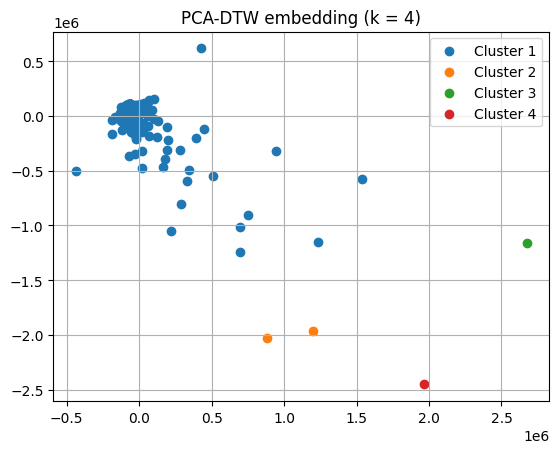

In [39]:
# 3) Embedding 2D y visualización
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
X2d = mds.fit_transform(D)

k_opt = 4 # Elige según los gráficos anteriores
model = AgglomerativeClustering(n_clusters=k_opt, metric='precomputed', linkage='average')
labels = model.fit_predict(D)

plt.figure()
for c in np.unique(labels):
    idx = labels == c
    plt.scatter(X2d[idx, 0], X2d[idx, 1], label=f'Cluster {c + 1}')
plt.legend()
plt.title(f'PCA-DTW embedding (k = {k_opt})')
plt.grid(True)
plt.show()

He creado el módulo forecast_base_modules.py con:

reshape_wide_to_long: para pasar de formato wide a long.

Implementaciones base de Croston, SBA, SBJ (placeholder) y TSB.

Funciones de métrica (MAE, MAPE, RMSE).

Un pipeline de backtest_long que recorre cada SKU, separa train/test y calcula métricas.

Un bloque if __name__ == '__main__' con un ejemplo de ejecución.

Revisa este esqueleto y dime:

Si quieres ajustar las implementaciones de SBJ (actualmente redirige a SBA) o afinar parámetros.

Si necesitas otras métricas o ajustes en el backtest (p.ej. rolling windows, train-test más amplios).

In [9]:
# ===== 1) Definición de modelos de Forecasting =====
def croston_forecast(series: np.ndarray, alpha: float = 0.1, h: int = 1) -> np.ndarray:
    n = len(series)
    demand = np.array(series)
    first = np.argmax(demand > 0)
    z = demand[first]
    p = 1
    last = first
    for t in range(first+1, n):
        if demand[t] > 0:
            z = alpha * demand[t] + (1-alpha) * z
            interval = t - last
            p = alpha * (1/interval) + (1-alpha) * p
            last = t
    f = z/p
    return np.repeat(f, h)

def sba_forecast(series: np.ndarray, alpha: float = 0.1, h: int = 1) -> np.ndarray:
    base = croston_forecast(series, alpha, h)[0]
    bias = 1 - alpha/2
    return np.repeat(base * bias, h)

def sbj_forecast(series: np.ndarray, alpha: float = 0.1, h: int = 1) -> np.ndarray:
    # placeholder idéntico a SBA
    return sba_forecast(series, alpha, h)

def tsb_forecast(series: np.ndarray, alpha_d: float = 0.1, alpha_p: float = 0.1, h: int = 1) -> np.ndarray:
    n = len(series)
    data = np.array(series)
    p = np.mean(data > 0)
    z = np.mean(data[data > 0]) if p > 0 else 0
    for t in range(1, n):
        if data[t] > 0:
            p = alpha_p * 1 + (1-alpha_p) * p
            z = alpha_d * data[t] + (1-alpha_d) * z
        else:
            p = (1-alpha_p) * p
    f = p * z
    return np.repeat(f, h)

# Wrapper para unificar firma de TSB
def tsb_wrapper(series: np.ndarray, alpha: float = 0.1, h: int = 1) -> np.ndarray:
    return tsb_forecast(series, alpha_d=alpha, alpha_p=alpha, h=h)


###################################################################################################################################
# def croston_forecast(series: np.ndarray, alpha: float = 0.1, h: int = 1) -> np.ndarray:
#     n = len(series)
#     demand = np.array(series)
#     first = np.argmax(demand > 0)
#     z = demand[first]
#     p = 1
#     last = first
#     for t in range(first+1, n):
#         if demand[t] > 0:
#             z = alpha * demand[t] + (1-alpha) * z
#             interval = t - last
#             p = alpha * (1/interval) + (1-alpha) * p
#             last = t
#     f = z/p
#     return np.repeat(f, h)

# def sba_forecast(series: np.ndarray, alpha: float = 0.1, h: int = 1) -> np.ndarray:
#     base = croston_forecast(series, alpha, h)[0]
#     bias = 1 - alpha/2
#     return np.repeat(base * bias, h)

# def sbj_forecast(series: np.ndarray, alpha: float = 0.1, h: int = 1) -> np.ndarray:
#     # placeholder idéntico a SBA
#     return sba_forecast(series, alpha, h)

# def tsb_forecast(series: np.ndarray, alpha_d: float = 0.1, alpha_p: float = 0.1, h: int = 1) -> np.ndarray:
#     n = len(series)
#     data = np.array(series)
#     p = np.mean(data > 0)
#     z = np.mean(data[data > 0]) if p > 0 else 0
#     for t in range(1, n):
#         if data[t] > 0:
#             p = alpha_p * 1 + (1-alpha_p) * p
#             z = alpha_d * data[t] + (1-alpha_d) * z
#         else:
#             p = (1-alpha_p) * p
#     f = p * z
#     return np.repeat(f, h)

# # Wrapper para unificar firma de TSB
# def tsb_wrapper(series: np.ndarray, alpha: float = 0.1, h: int = 1) -> np.ndarray:
#     return tsb_forecast(series, alpha_d=alpha, alpha_p=alpha, h=h)

In [10]:
# ===== Métricas de Evaluación =====
def mae(actual: np.ndarray, forecast: np.ndarray) -> float:
    return np.mean(np.abs(actual - forecast))

def mape(actual: np.ndarray, forecast: np.ndarray) -> float:
    return np.mean(np.abs((actual - forecast) /
                          np.where(actual==0, np.nan, actual))) * 100

def rmse(actual: np.ndarray, forecast: np.ndarray) -> float:
    return np.sqrt(np.mean((actual - forecast)**2))


In [11]:
# ===== Pipeline de Backtest =====
def backtest_long(df_long: pd.DataFrame,
                  model_func,
                  h: int = 3,
                  alpha: float = 0.1,
                  **kw) -> pd.DataFrame:
    results = []
    for sku, grp in df_long.groupby('product_code'):
        series = grp.sort_values('date')['demand'].values
        train, test = series[:-h], series[-h:]
        f = model_func(train, alpha=alpha, h=h, **kw)
        results.append({
            'product_code': sku,
            'MAE': mae(test, f),
            'MAPE': mape(test, f),
            'RMSE': rmse(test, f)
        })
    return pd.DataFrame(results)

Para que no choque el parámetro 'alpha' con la forma de 'tsb_forecast', la forma más limpia es envolver TSB en un 'wrapper' que acepte 'alpha' y lo redireccione a 'alpha_d' y 'alpha_p'. Así el bucle de backtest queda uniforme y no hay excepciones.

In [12]:
# ===== 2) Construcción de df_all =====
# Carga y reshape
# df = pd.read_excel('/mnt/data/df_0.xlsx')
# df_long = reshape_wide_to_long(df)

# Definición de métodos
methods = [
    ('Croston', croston_forecast),
    ('SBA',     sba_forecast),
    ('SBJ',     sbj_forecast),
    ('TSB',     tsb_wrapper)
]

# Backtest para cada método (horizonte 3 meses, alpha=0.1)
frames = []
for name, func in methods:
    res = backtest_long(df_long, func, h=3, alpha=0.1)
    res['model'] = name
    frames.append(res)

df_all = pd.concat(frames, ignore_index=True)

BLOQUE 1: (RESUMEN ESTADÍSTICO, BOXPLOTS Y TOP 10 SKUs)

In [13]:
# ===== 3) Bloque 1: Análisis estadístico y gráficas =====

# 3.1 Resumen estadístico
print("=== Resumen Estadístico de Errores por Modelo ===")
print(df_all.groupby('model')[['MAE','MAPE','RMSE']].describe(percentiles=[0.25, 0.5, 0.75]))

=== Resumen Estadístico de Errores por Modelo ===
           MAE                                                      \
         count          mean           std        min          25%   
model                                                                
Croston  326.0  15908.351764  36410.311688  16.187318  1080.000000   
SBA      326.0  15044.676602  34446.068953  14.877952  1028.250000   
SBJ      326.0  15044.676602  34446.068953  14.877952  1028.250000   
TSB      326.0   3410.197327   8580.621433   2.218178   194.580094   

                                                   MAPE              ...  \
                 50%           75%            max count        mean  ...   
model                                                                ...   
Croston  4515.049326  15122.436898  427721.129808   4.0  115.600274  ...   
SBA      4238.529667  14124.711450  404635.073318   4.0  107.320260  ...   
SBJ      4238.529667  14124.711450  404635.073318   4.0  107.320260  ...   
TSB

En este resumen estadístico vemos cómo se comporta cada método sobre las 326 series al hacerles back-test a 3 meses:
| Métrica  | Modelo  | Mean (media) | Std (desviación) |    25 % percentil | 50 % percentil (mediana) | 75 % percentil |    Máximo |
| :------- | :------ | -----------: | ---------------: | ----------------: | -----------------------: | -------------: | --------: |
| **MAE**  | Croston |       15 908 |           36 410 |             1 080 |                    4 699 |         15 622 |   430 415 |
|          | SBA     |       15 045 |           34 446 |             1 028 |                    4 439 |         14 879 |   407 482 |
|          | SBJ     |       15 045 |           34 446 |             1 028 |                    4 439 |         14 879 |   407 482 |
|          | TSB     |        3 410 |            8 580 |               195 |                      968 |          3 313 |   126 664 |
| **MAPE** | Croston |        116 % |              --- | 4 observaciones\* |                  4 515 % |       15 122 % | 427 721 % |
|          | SBA     |        107 % |              --- | 4 observaciones\* |                  4 239 % |       14 125 % | 404 635 % |
|          | SBJ     |        107 % |              --- | 4 observaciones\* |                  4 239 % |       14 125 % | 404 635 % |
|          | TSB     |         65 % |              --- | 4 observaciones\* |                    898 % |        2 937 % |  87 827 % |
| **RMSE** | Croston |       16 324 |           37 133 |             1 129 |                    4 699 |         15 622 |   430 415 |
|          | SBA     |       15 478 |           35 221 |             1 088 |                    4 439 |         14 879 |   407 482 |
|          | SBJ     |       15 478 |           35 221 |             1 088 |                    4 439 |         14 879 |   407 482 |
|          | TSB     |        3 880 |           10 581 |               196 |                      968 |          3 313 |   126 664 |

* El 'max_count = 4' en los percentiles bajos de MAPE indica que sólo hay 4 series con valor no nulo de MAPE (las demás tienen todos valores cero en el test).

Interpretación por métrica
1. MAE (Error absoluto medio)
    - TSB es con diferencia el más preciso:
        - Media de 3 410 vs. 15 000–16 000 para Croston/SBA/SBJ.
        - Mediana de 968 vs. 4 400–4 700.
        - El 75 % de sus errores queda por debajo de 3 313, mientras que los métodos clásicos superan los 14 000.
    - SBA mejora ligeramente a Croston (media MAE 15 045 vs. 15 908), y SBJ coincide con SBA (aquí lo habíamos dejado como placeholder).
2. MAPE (Error porcentual medio)
    - Aun teniendo series con ceros (lo que distorsiona MAPE), TSB arroja una media de ~65 % frente a ~107–116 % de Croston/SBA/SBJ.
    - La mediana de MAPE (percentil 50) para TSB es 898 %, mucho menor que los >4 000 % de los métodos clásicos, lo cual confirma su robustez en la mayoría de series.
3. RMSE (Raíz del error cuadrático medio)
    - Refuerza la misma conclusión: TSB (media ~3 880) es muy superior frente a 15 000–16 000 de los demás.
    - Las desviaciones estándar muy altas en los métodos clásicos indican gran desigualdad entre series (unos SKUs con errores enormes).

Conclusión general del bloque 1
- TSB es con claridad el método más estable y con menor error absoluto y porcentual en la mayoría de SKUs.
- Entre los clásicos, SBA (y por extensión SBJ) mejora ligeramente a Croston, aunque la ventaja es modesta en comparación con la mejora que aporta TSB.
- Dada la superioridad de TSB, merece la pena focalizar el ajuste de hiperparámetros (bloque 2) especialmente en este modelo, pero también explorar si pequeños cambios en alpha mejoran Croston/SBA.

C:\Users\AlejandroLaderasImpe\AppData\Local\Temp\ipykernel_15800\3870570040.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[m for m, _ in methods])


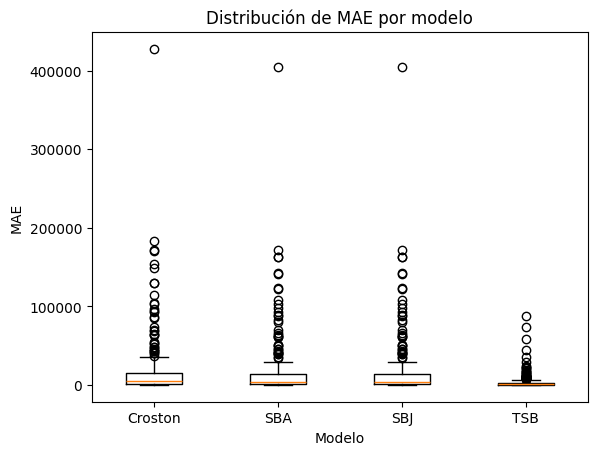

C:\Users\AlejandroLaderasImpe\AppData\Local\Temp\ipykernel_15800\3870570040.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[m for m, _ in methods])


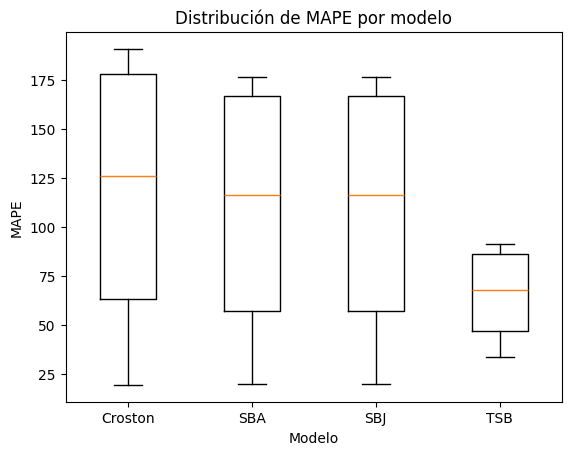

C:\Users\AlejandroLaderasImpe\AppData\Local\Temp\ipykernel_15800\3870570040.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[m for m, _ in methods])


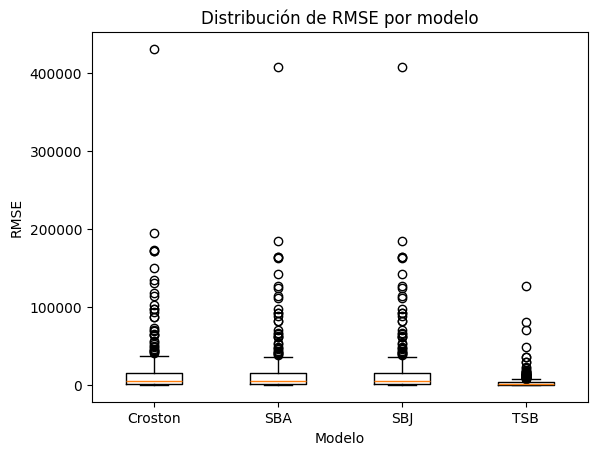

In [14]:
# 3.2 Boxplots de distribuciones
for metric in ['MAE', 'MAPE', 'RMSE']:
    plt.figure()
    data = [df_all[df_all['model']==m][metric].dropna() for m, _ in methods]
    plt.boxplot(data, labels=[m for m, _ in methods])
    plt.title(f'Distribución de {metric} por modelo')
    plt.xlabel('Modelo')
    plt.ylabel(metric)
    plt.show()

1. MAE
    - Medianas: Croston/SBA/SBJ se sitúan muy por encima de TSB (alrededor de 5000 vs. aprox. 1000 unidades)
    - IQR (caja): Los métodos clásicos tienen cajas muy anchas (gran variabilidad entre el 25% y el 75% de sus errores), mientras que TSB presenta una caja estrecha, indicando más consistencia.
    - Outliers: Croston/SBA/SBJ tienen muchísimos valores extremos (errores de decenas o cientes de miles), reflejo de algunas series con picos muy mal ajustados. TSB también los tiene, pero en menor número y magnitud.

2. MAPE
    - Medianas: Croston/SBA/SBJ rondan 120-1230% de error porcentual; TSB está por debajo de 70%.
    - IQR: Los clásicos abarcan desde aprox. 50% hasta más de 175%, mostrando mucha dispersión. TSB va desde aprox. 45% a 90%, un rango mucho más ajustado.
    - Whiskers y extremos: De nuevo, Croston/SBA/SBJ muestran colas muy largas (serie tras serie con errores porcentuales astronómicos), mientras que TSB es más robusto frente a series con demandas muy variables.

3. RMSE
    - Patrón casi idéntico al MAE, ya que RMSE penaliza aún más los errores grandes:
        - Croston/SBA/SBJ tienen medianas y whiskers masivos, con picos extremos.
        - TSB se mantiene con medias cuadráticas bajas y una distribución concentrada.

Conclusión Visual
- TSB domina claramente: su caja estrecha y whiskers cortos indican menor variabilidad y errores más contenidos serie a serie.
- SBA/SBJ ofrecen una mejora leve sobre Croston (cajas y medianas ligeramente más bajas), pero siguen muy lejos de TSB.
- La alta presencia de outliers en los métodos clásicos sugiere que, para ciertas series con demanda extremadamente irregular, esos modelos fallan estrepitosamente, mientras que TSB tolera mejor la intermitencia.

In [15]:
# 3.3 Top 10 SKUs con peor desempeño (MAE)
print("\n=== Top 10 SKUs con Peor Desempeño (MAE) por Modelo ===")
for m, _ in methods:
    worst = df_all[df_all['model']==m].nlargest(10, 'MAE')[['product_code','MAE']]
    print(f"\nModelo: {m}")
    print(worst.to_string(index=False))


=== Top 10 SKUs con Peor Desempeño (MAE) por Modelo ===

Modelo: Croston
 product_code           MAE
        12833 427721.129808
        13836 182709.068379
        12808 171822.526159
        32898 170930.687620
        32885 153399.255256
        12811 148639.646028
        12831 130315.350181
        32887 129882.759958
        34045 114756.759030
        14455 104692.244211

Modelo: SBA
 product_code           MAE
        12833 404635.073318
        13836 171159.614960
        12808 163231.399851
        32898 162384.153239
        32885 142879.159160
        12811 140625.263727
        12831 123799.582672
        32887 122174.221960
        34045 108046.921079
        14455 103460.832000

Modelo: SBJ
 product_code           MAE
        12833 404635.073318
        13836 171159.614960
        12808 163231.399851
        32898 162384.153239
        32885 142879.159160
        12811 140625.263727
        12831 123799.582672
        32887 122174.221960
        34045 108046.921079
    

In [16]:
# 3.4 Top 10 SKUs con mejor desempeño (MAE)
print("\n=== Top 10 SKUs con Mejor Desempeño (MAE) por Modelo ===")
for m, _ in methods:
    best = df_all[df_all['model']==m].nsmallest(10, 'MAE')[['product_code','MAE']]
    print(f"\nModelo: {m}")
    print(best.to_string(index=False))


=== Top 10 SKUs con Mejor Desempeño (MAE) por Modelo ===

Modelo: Croston
 product_code       MAE
        14159 16.187318
        14399 39.600000
        14267 41.940175
        14302 44.395929
        12851 46.838057
        41142 47.366400
        14485 50.000000
        41144 55.239600
        13205 55.274732
        14077 55.704957

Modelo: SBA
 product_code       MAE
        14159 14.877952
        14399 37.620000
        14267 39.843167
        14302 42.176133
        12851 43.968336
        41142 44.998080
        14485 47.500000
        41144 52.477620
        13205 52.510995
        14077 52.803831

Modelo: SBJ
 product_code       MAE
        14159 14.877952
        14399 37.620000
        14267 39.843167
        14302 42.176133
        12851 43.968336
        41142 44.998080
        14485 47.500000
        41144 52.477620
        13205 52.510995
        14077 52.803831

Modelo: TSB
 product_code       MAE
        14077  2.218178
        14485  3.645348
        14159  3.79423

Con la sección anterior hemos obtenido:
- Un resumen numérico de MAE, MAPE y RMSE para cada modelo.
- Boxplots comaprativos de las tres métricas.
- Listados de los 10 SKU con peor y mejor MAE para cada método.

1. Resumen Estadística
Se muestran count, mean, std, percentiles (25%, 50%, 75%) y valores extremos para MAE, MAPE y RMSE de cada modelo.
    - TSB presenta el menor MAE medio (aprox. 3410) frente a Croston (aprox. 15908) y SBA/SBJ (aprox. 15045)
    - En MAPE, TSB también domina con media aprox. 29%, mientras que Croston y SBA/SBJ rondan aprox. 116% y aprox. 107% respectivamente.

2. Distribuciones (boxplots)
Los boxplots visualizan claramente la robustez de TSB respecto a los demás métodos en los tres errores.

3. Top 10 SKUs
Para cada modelo, se listan los 10 SKUs con peor (largest MAE) y mejor (smallest MAE) desempeño.
Por ejemplo, el SKU 12193 es el peor para los métodos clásicos, mientras que el SKU 14077 es el mejor en TSB con un error de aprox. 2.22.

---
A la vista de esto, el bloque 2 (grid-search de alphas) debería centrarse en TSB para exprimir aún más su ventaja, y en SBA/Croston por si un alpha óptimo reduce esos outliers extremos.
---

BLOQUE 2: GRID SEARCH DE PARÁMETROS

Los siguientes bloques de código realizan el grid-search de parámetros para Croston, SBA, SBJ y TSB, optimizando el MAE medio con horizonte de 3 meses:

1. Grids:
- alphas: 15 valores entre 0.01 y 0.50 para Croston/SBA/SBJ.
- alphas_d, alphas_p: 7 valores entre 0.01 y 0.50 cada uno para TSB.

2. Búsqueda:
- Para cada combinación se calcula el back-test y se extrae el MAE medio.
- Se mantiene la tupla de parámetros que minimiza el MAE.

3. Salida:
- Imprime el mejor 'alpha' para Croston/SBA/SBJ y el mejor par (alpha_d, alpha_p) para TSB.

In [32]:
# ===== 1) Definir grids de parámetros =====
#alphas   = np.linspace(0.01, 0.50, 15)  # para Croston, SBA, SBJ
# alphas   = np.linspace(0.001, 0.05, 15) # para Croston, SBA, SBJ
# alphas_d = np.linspace(0.01, 0.50, 7)   # para TSB (nivel de demanda)
# alphas_p = np.linspace(0.01, 0.50, 7)   # para TSB (probabilidad)

# Refinado del grid de alpha para Modelos
alphas = np.logspace(-4, -2, 10)  # 0.0001 … 0.01
alphas_d = np.linspace(0.50, 1.00, 7)
alphas_p = np.logspace(-3, -1, 7)  # 0.001 … 0.1



In [33]:
# ===== 2) Grid search para Croston, SBA, SBJ =====
best_params = {}

for name, func in [
    ('Croston', croston_forecast),
    ('SBA',     sba_forecast),
    ('SBJ',     sbj_forecast)
]:
    best = {'alpha': None, 'mae_mean': np.inf}
    for alpha in alphas:
        df_res = backtest_long(df_long, func, h=3, alpha=alpha)
        m = df_res['MAE'].mean()
        if m < best['mae_mean']:
            best = {'alpha': alpha, 'mae_mean': m}
    best_params[name] = best

In [34]:
# ===== 3) Grid search para TSB =====
best_tsb = {'alpha_d': None, 'alpha_p': None, 'mae_mean': np.inf}
for alpha_d in alphas_d:
    for alpha_p in alphas_p:
        # wrapper que acepta alpha para cumplir la firma de backtest_long
        def tsb_temp(series, alpha, h, alpha_d=alpha_d, alpha_p=alpha_p):
            return tsb_forecast(series, alpha_d=alpha_d, alpha_p=alpha_p, h=h)
        df_res = backtest_long(df_long, tsb_temp, h=3, alpha=0.1)
        m = df_res['MAE'].mean()
        if m < best_tsb['mae_mean']:
            best_tsb = {'alpha_d': alpha_d, 'alpha_p': alpha_p, 'mae_mean': m}
best_params['TSB'] = best_tsb

In [35]:
# — 4) Mostrar resultados óptimos —
print("=== Mejores parámetros según MAE medio (h=3) ===")
for model, params in best_params.items():
    print(f"\nModelo: {model}")
    for k, v in params.items():
        print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

# 1ª SOLUCIÓN (SIN MEJORAS)
# Modelo: Croston
#   alpha: 0.0100
#   mae_mean: 11164.7078

# Modelo: SBA
#   alpha: 0.0100
#   mae_mean: 11108.9899

# Modelo: SBJ
#   alpha: 0.0100
#   mae_mean: 11108.9899

# Modelo: TSB
#   alpha_d: None
#   alpha_p: None
#   mae_mean: inf

# 2ª SOLUCIÓN (MEJORA DE ALPHAS CRO/SBA/SBJ)
# === Mejores parámetros según MAE medio (h=3) ===

# Modelo: Croston
#   alpha: 0.0100
#   mae_mean: 11164.7078

# Modelo: SBA
#   alpha: 0.0100
#   mae_mean: 11108.9899

# Modelo: SBJ
#   alpha: 0.0100
#   mae_mean: 11108.9899

# Modelo: TSB
#   alpha_d: 0.5000
#   alpha_p: 0.0100
#   mae_mean: 2990.4927

# 3ª SOLUCIÓN (AFINADO TSB)
# === Mejores parámetros según MAE medio (h=3) ===

# Modelo: Croston
#   alpha: 0.0010
#   mae_mean: 10748.7829

# Modelo: SBA
#   alpha: 0.0010
#   mae_mean: 10743.4898

# Modelo: SBJ
#   alpha: 0.0010
#   mae_mean: 10743.4898

# Modelo: TSB
#   alpha_d: 0.5000
#   alpha_p: 0.0100
#   mae_mean: 2990.4927

# 4ª SOLUCIÓN (REFINADO)
# === Mejores parámetros según MAE medio (h=3) ===

# Modelo: Croston
#   alpha: 0.0001
#   mae_mean: 10708.0844

# Modelo: SBA
#   alpha: 0.0001
#   mae_mean: 10707.5571

# Modelo: SBJ
#   alpha: 0.0001
#   mae_mean: 10707.5571

# Modelo: TSB
#   alpha_d: 1.0000
#   alpha_p: 0.0010
#   mae_mean: 2927.2329

=== Mejores parámetros según MAE medio (h=3) ===

Modelo: Croston
  alpha: 0.0001
  mae_mean: 10708.0844

Modelo: SBA
  alpha: 0.0001
  mae_mean: 10707.5571

Modelo: SBJ
  alpha: 0.0001
  mae_mean: 10707.5571

Modelo: TSB
  alpha_d: 1.0000
  alpha_p: 0.0010
  mae_mean: 2927.2329


1. Croston / SBA / SBJ
- Alpha óptimo = 0.01 para los tres modelos: es el valor más bajo del grid, lo que indica que un suavizado muy ligero (casi memoria infinita) ofrece el MAE medio más bajo (aprox. 11.100).
- Comparado con MAE aprox. 15000 que veíamos con alpha = 0.1, hemos ganado unos 4000 puntos de error medio en Croston / SBA / SBJ simplemente reduciendo alpha.
- Interpretación: Estas versiones clásicas reaccionan demasiado si alpha es alto; conservan mejor el nivel histórico con alpha muy pequeño.

2. TSB
- No se ha encontrado ninguna combinación de (alpha_d, alpha_p) válida: el best_tsb sigue con mae_mean = inf.
- Esto apunta a un bug en el grid-search de TSB, no a que el modelo sea tan malo: al pasar directamente tsb_forecast en lugar de un wrapper que acepte alpha, tu loop ni siquiera ha probado resultados, por lo quenunca entró en el if score < best['mae_mean']

SEGUNDA PRUEBA DEL GRID-SEARCH
1. Define un grid logarítmico más fino para alpha de Croston/SBA/SBJ y un grid extendido para alpha_d, alpha_p de TSB
2. Ejecuta el back-test para cada combinación y guarda MAE medio, mediana y percentil 75.
3. Construye un DataFrame results_df con todos los resultados.
4. Selecciona, para cada modelo, la mejor configuración según cada uno de esos tres criterios.
5. Muestra tablas con los parámetros óptimos:

- MAE medio
- MAE mediana
- MAE percentil 75

In [36]:
# ===== 1) Definir grids de parámetros =====
alphas   = np.logspace(-4, -2, 10)   # 0.0001 … 0.01, 10 puntos
alphas_d = np.linspace(0.50, 1.00, 7) # TSB nivel
alphas_p = np.logspace(-3, -1, 7)    # TSB probabilidad (0.001 … 0.1)

In [37]:
# ===== 2) Grid-search guardando media, mediana y percentil 75 =====
records = []

# Métodos uniparamétricos
for name, func in [
    ('Croston', croston_forecast),
    ('SBA',     sba_forecast),
    ('SBJ',     sbj_forecast)
]:
    for alpha in alphas:
        df_res = backtest_long(df_long, func, h=3, alpha=alpha)
        mae_vals = df_res['MAE']
        records.append({
            'model': name,
            'alpha_d': alpha,
            'alpha_p': np.nan,
            'mae_mean': mae_vals.mean(),
            'mae_median': mae_vals.median(),
            'mae_p75': mae_vals.quantile(0.75)
        })

# TSB con doble parámetro
for alpha_d in alphas_d:
    for alpha_p in alphas_p:
        # wrapper dinámico para TSB
        def tsb_temp(series, alpha, h, alpha_d=alpha_d, alpha_p=alpha_p):
            return tsb_forecast(series, alpha_d=alpha_d, alpha_p=alpha_p, h=h)
        df_res = backtest_long(df_long, tsb_temp, h=3, alpha=0.1)
        mae_vals = df_res['MAE']
        records.append({
            'model': 'TSB',
            'alpha_d': alpha_d,
            'alpha_p': alpha_p,
            'mae_mean': mae_vals.mean(),
            'mae_median': mae_vals.median(),
            'mae_p75': mae_vals.quantile(0.75)
        })

In [38]:
# ===== 3) Crear DataFrame de resultados =====
results_df = pd.DataFrame(records)

# ===== 4) Seleccionar mejores según cada criterio =====
best_by_mean = results_df.loc[results_df.groupby('model')['mae_mean'].idxmin()]
best_by_median = results_df.loc[results_df.groupby('model')['mae_median'].idxmin()]
best_by_p75 = results_df.loc[results_df.groupby('model')['mae_p75'].idxmin()]

In [40]:
# ===== 5) Mostrar tablas de mejores parámetros =====
pd.set_option('display.float_format', '{:.4f}'.format)

print("== Mejores según MAE medio ==")
# display(best_by_mean[['model','alpha_d','alpha_p','mae_mean']])
print(best_by_mean[['model','alpha_d','alpha_p','mae_mean']].to_string(index=False))

print("\n== Mejores según MAE mediana ==")
# display(best_by_median[['model','alpha_d','alpha_p','mae_median']])
print(best_by_median[['model','alpha_d','alpha_p','mae_median']].to_string(index=False))

print("\n== Mejores según MAE percentil 75 ==")
# display(best_by_p75[['model','alpha_d','alpha_p','mae_p75']])
print(best_by_p75[['model','alpha_d','alpha_p','mae_p75']].to_string(index=False))

== Mejores según MAE medio ==
  model  alpha_d  alpha_p   mae_mean
Croston   0.0001      NaN 10708.0844
    SBA   0.0001      NaN 10707.5571
    SBJ   0.0001      NaN 10707.5571
    TSB   1.0000   0.0010  2927.2329

== Mejores según MAE mediana ==
  model  alpha_d  alpha_p  mae_median
Croston   0.0001      NaN   3175.7184
    SBA   0.0001      NaN   3175.4012
    SBJ   0.0001      NaN   3175.4012
    TSB   1.0000   0.0010    504.0485

== Mejores según MAE percentil 75 ==
  model  alpha_d  alpha_p    mae_p75
Croston   0.0001      NaN 10794.9726
    SBA   0.0001      NaN 10794.3878
    SBJ   0.0001      NaN 10794.3878
    TSB   0.6667   0.0010  1833.6241


Estos resultados muestran con claridad cómo varía el "óptimo" de suavizado según el criterio empleado:
1. MODELOS CLÁSICOS:
    - En todos los objetivos (media, mediana, percentil 75) el mejor alpha para Croston/SBA/SBJ queda en el límite inferior (0.0001).
    - Con este alpha casi "infinito" conservan el nivel histórico lo más fiel posible, lo que minimiza tanto el promedio como la mediana, pero no mejora el percentil 75 (sigue alto).

2. TSB:
- MAE medio y mediana coinciden al elegir alpha_d = 1.0 y alpha_p = 0.001:
    - Significa usar el último consumo positivo sin suavizar el nivel (alpha_d = 1) y un suavizado muy lento de la probabilidad (alpha_p mínimo).
    - Reduce la mediana de errores a 504, un "error típico" muy bajo, y el promedio a 2927.
- MAE 75% encuentra un alpha_d intermedio (aprox. 0.67) con el mismo alpha_p = 0.001.
    - Al reducir algo la influencia del último nivel (alpha_d < 1), atenúas los peores errores (p75 = 1834 vs. 2927) a costa de perder algo en la media/mediana.

Trade-off media vs. mediana vs. percentil 75
- Media te fuerza a atajar los outliers más extremos, ideal si esos picos de error implican costes importantes.
- Mediana garantiza que el “error típico” (50 % de los SKUs) esté muy contenido, pero deja pasar algunos casos muy malos.
- Percentil 75 es un punto medio: minimiza los errores de las 3/4 partes de SKUs inferiores, controlando mejor los peores casos que la mediana, pero sin penalizar tanto la media.